In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np

import xarray as xr

import regionmask

import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
import matplotlib.patches as mpatches
import cmocean

import glob


import sys
sys.path.append('../')
import utils
import plotting

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

# Import Data

### Load in GEOS Chem Runs made from File Creation Notebook, Load in HEMCO Emissions Files

In [2]:
ds= xr.open_dataset('./final_data/ds_PM_O3_daily.nc4')


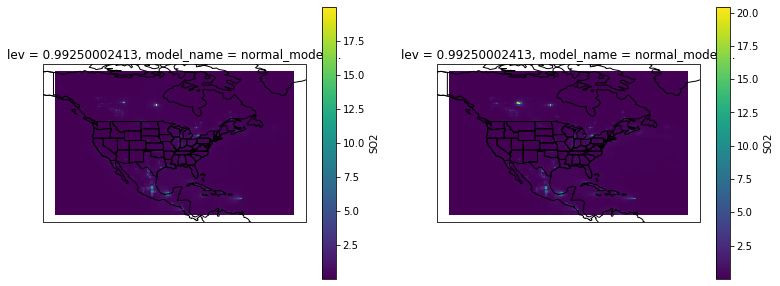

In [30]:
fig = plt.figure(figsize = [20,5])
            
for m in np.arange(4,6):
    ax = fig.add_subplot(1,3,m-2, projection=ccrs.PlateCarree())
    (ds['SO2'].sel(model_name = 'normal_model')).groupby('time.month').mean().sel(month = m).plot(ax = ax, transform=ccrs.PlateCarree())
    ax.add_feature(cfeat.STATES)
    ax.coastlines() #add coastlines
    #ax.set_extent([-120,-70,20,50]) #set a limit on the plot lat and lon
plt.savefig('monthly_diagnosis.png', dpi = 150, bbox_inches = 'tight')

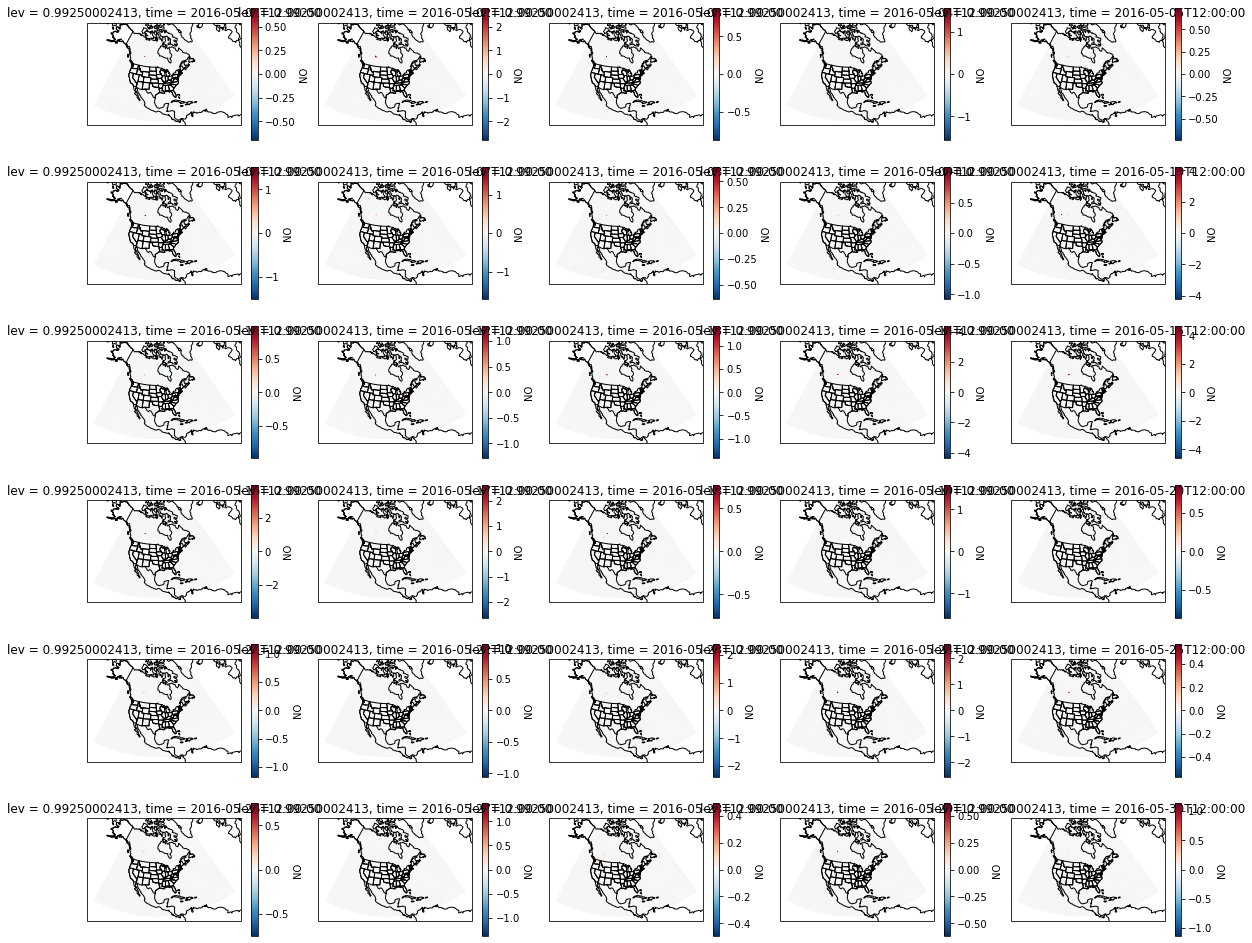

In [28]:
fig = plt.figure(figsize = [20,20])
            
for m in np.arange(1,31):
    ax = fig.add_subplot(7,5,m, projection=ccrs.LambertConformal())
    (ds['NO'].sel(model_name = 'nonuc_model')-ds['NO'].sel(model_name = 'normal_model')).sel(time = f"2016-05-{m}").plot(ax = ax, transform=ccrs.PlateCarree())
    ax.add_feature(cfeat.STATES)
    ax.coastlines() #add coastlines
    #ax.set_extent([-120,-70,20,50]) #set a limit on the plot lat and lon
plt.savefig('monthly_diagnosis.png', dpi = 150, bbox_inches = 'tight')

ds_emis = xr.open_zarr('./data/emissions_HEMCO')

### Define variables and lists

In [30]:
#define Lat and Lon of the nested grid US

levels_dict = {'PM25':np.arange(0., 40., .5), 'SO2':np.arange(0., 5., .1), 
               'NO2':np.arange(0., 5., .1), 'NOx':np.arange(0., 5., .1), 'O3':np.arange(0., 40., 1.),
               'dif':np.arange(-1., 1.01, .01), 'regional_dif':np.arange(-1.5, 1.51, .01), 'regional_dif_tight':np.arange(-.3, .31, .01),
              'percent_dif_full':np.arange(-100, 101, 1), 'percent_dif_tight':np.arange(-10,10.1,.1)}


species_dict = {'PM25':'PM2.5 - Local Conditions', 'SO2':'Sulfur Dioxide', 'NO2':'Nitrogen dioxide (NO2)', 'O3':'Ozone', 'NOx':'Nitrogen Oxides (NO2+NO)'}

model_names = ds['model_name'].values

cmap_dif = 'PRGn_r'
cmap_conc = 'PuBu'
cmap_discrete = cm.get_cmap('Paired', 3) 

# Plots

## US, concentrations

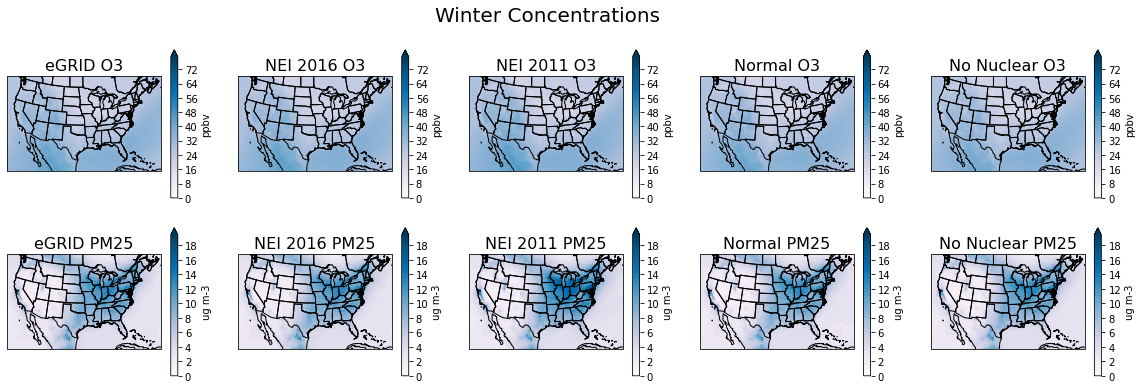

In [31]:
plotting.concentration_plot_seasonal(ds = ds, species_names = ['O3','PM25'], season = 'DJF', model_names = model_names,  cmap = cmap_conc,
                        lat_lon = [-120,-70,20,50], shrink_cbar = 1,
                       figsize = [20,6])
plt.suptitle('Winter Concentrations', fontsize = 20);
plt.savefig('./Figures/supp_winter_conc.png',bbox_inches = 'tight', dpi = 150)

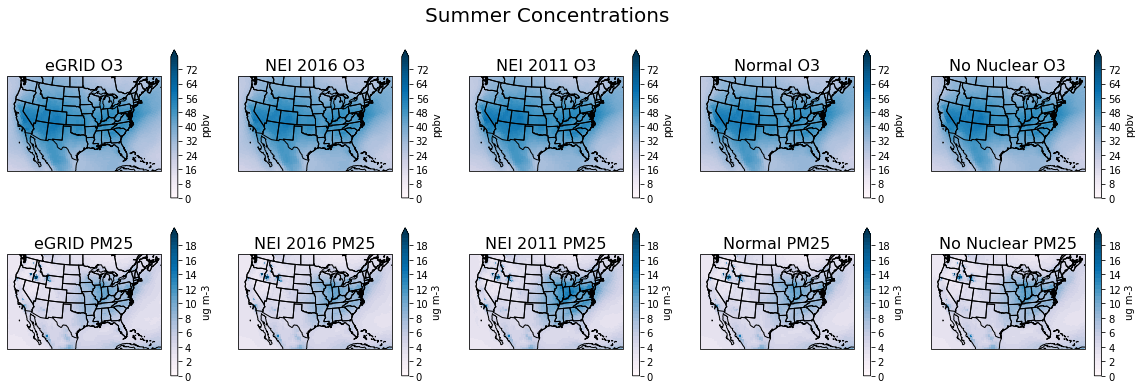

In [32]:
plotting.concentration_plot_seasonal(ds = ds, species_names = ['O3','PM25'], season = 'JJA', model_names = model_names,  cmap = cmap_conc,
                        lat_lon = [-120,-70,20,50], shrink_cbar = 1,
                       figsize = [20,6])
plt.suptitle('Summer Concentrations', fontsize = 20);
plt.savefig('./Figures/supp_summer_conc.png',bbox_inches = 'tight', dpi = 150)

## US, differences Normal and No Nuclear

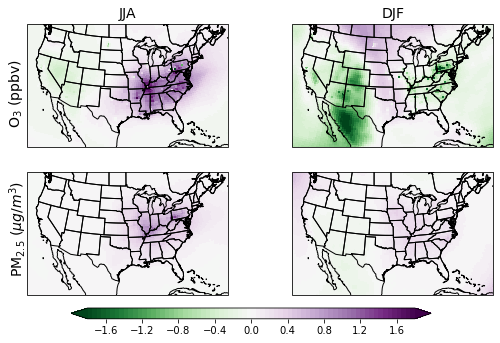

In [14]:
plotting.concentration_plot_seasonal_dif(ds = ds, seasons = ['JJA','DJF'], species_names = ['O3','PM25'], cmap = cmap_dif,
                   rows = 2, columns = 2, levels = np.arange(-1.8,1.85,.05), lat_lon = [-120,-70,20,50],
                   figsize = [10, 5], extension = 'both')
plt.savefig('./Figures/PM_O3_dif.png', bbox_inches = 'tight', dpi = 150)

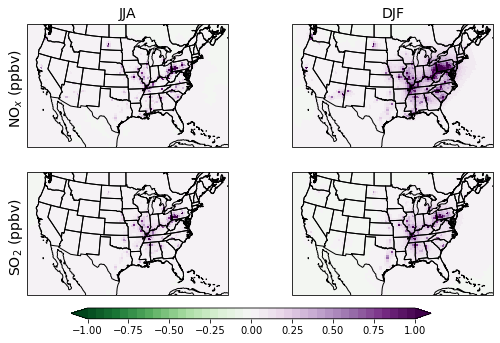

In [48]:
plotting.concentration_plot_seasonal_dif(ds = ds, seasons = ['JJA','DJF'], species_names = ['NOx','SO2'], cmap = cmap_dif,
                   rows = 2, columns = 2, levels = np.arange(-1.,1.05,.05), lat_lon = [-120,-70,20,50],
                   figsize = [10, 5], extension = 'both')
plt.savefig('./Figures/nox_so2_dif.png', bbox_inches = 'tight', dpi = 150)

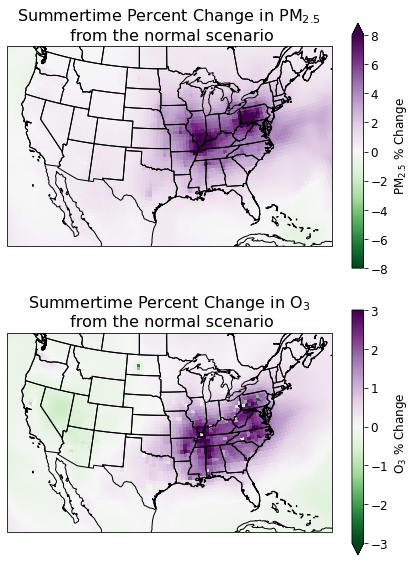

In [18]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize = (6,8), subplot_kw={'projection':ccrs.LambertConformal()})


im1 = ((ds['PM25'].sel(model_name = 'nonuc_model') - 
    ds['PM25'].sel(model_name = 'normal_model'))*100/ds['PM25'].sel(model_name = 'normal_model')).groupby('time.season').mean().sel(season = 'JJA').plot(
    ax = ax1, cmap = cmap_dif, vmin = -8, vmax = 8, transform = ccrs.PlateCarree(),add_colorbar=False)
cb1 = plt.colorbar(im1, ax = ax1, orientation="vertical", pad=0.05, extend = 'max')
cb1.set_label(label=r'PM$_{2.5}$ % Change', size='large')
cb1.ax.tick_params(labelsize='large')
ax1.add_feature(cfeat.STATES)
ax1.coastlines() #add coastlines
ax1.set_extent([-120,-70,20,50]) #set a limit on the plot lat and lon
ax1.set_title(r'Summertime Percent Change in PM$_{2.5}$'' \n from the normal scenario', fontsize = 16);

im2 = ((ds['O3'].sel(model_name = 'nonuc_model') - 
    ds['O3'].sel(model_name = 'normal_model'))*100/ds['O3'].sel(model_name = 'normal_model')).groupby('time.season').mean().sel(season = 'JJA').plot(
    ax = ax2, cmap = cmap_dif, vmin = -3, vmax = 3, transform = ccrs.PlateCarree(),add_colorbar=False)
cb2 = plt.colorbar(im2, ax = ax2, orientation="vertical", pad=0.05, extend = 'min')
cb2.set_label(label=r'O$_3$ % Change', size='large')
cb2.ax.tick_params(labelsize='large')
ax2.add_feature(cfeat.STATES)
ax2.coastlines() #add coastlines
ax2.set_extent([-120,-70,20,50]) #set a limit on the plot lat and lon
ax2.set_title(r'Summertime Percent Change in O$_{3}$'' \n from the normal scenario', fontsize = 16);

fig.tight_layout()

## NAAQS standards


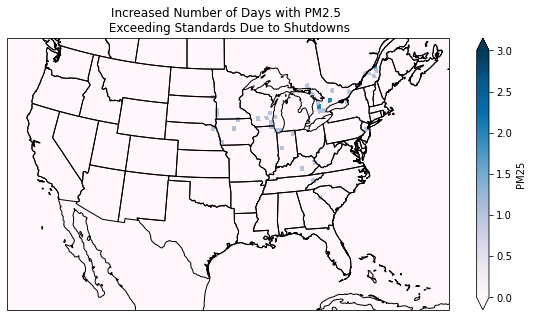

In [41]:
fig, ax = plt.subplots(figsize = (10,5), subplot_kw={'projection':ccrs.LambertConformal()})
(ds['PM25'].where(ds['PM25'] >35).count(dim = 'time').sel(model_name = 'nonuc_model') - 
    ds['PM25'].where(ds['PM25'] >35).count(dim = 'time').sel(model_name = 'normal_model')).plot(ax = ax, cmap = 'PuBu', vmin = 0, vmax = 3, transform = ccrs.PlateCarree())
ax.add_feature(cfeat.STATES)
ax.coastlines() #add coastlines
ax.set_extent([-120,-70,20,50]) #set a limit on the plot lat and lon
plt.title('Increased Number of Days with PM2.5 \n Exceeding Standards Due to Shutdowns');

# Come back to fix this

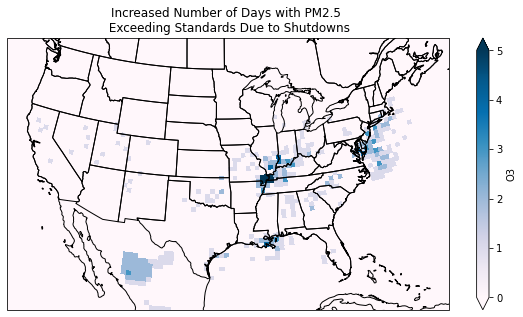

In [47]:
fig, ax = plt.subplots(figsize = (10,5), subplot_kw={'projection':ccrs.LambertConformal()})
(ds['O3'].where(ds['O3'] >70).count(dim = 'time').sel(model_name = 'nonuc_model') - 
    ds['O3'].where(ds['O3'] >70).count(dim = 'time').sel(model_name = 'normal_model')).plot(ax = ax, cmap = 'PuBu', vmin = 0, vmax = 5, transform = ccrs.PlateCarree())
ax.add_feature(cfeat.STATES)
ax.coastlines() #add coastlines
ax.set_extent([-120,-70,20,50]) #set a limit on the plot lat and lon
plt.title('Increased Number of Days with PM2.5 \n Exceeding Standards Due to Shutdowns');

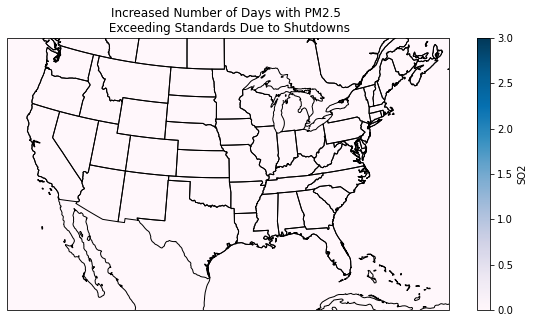

In [44]:
fig, ax = plt.subplots(figsize = (10,5), subplot_kw={'projection':ccrs.LambertConformal()})
(ds['SO2'].where(ds['SO2'] >75).count(dim = 'time').sel(model_name = 'nonuc_model') - 
    ds['SO2'].where(ds['SO2'] >75).count(dim = 'time').sel(model_name = 'normal_model')).plot(ax = ax, cmap = 'PuBu', vmin = 0, vmax = 3, transform = ccrs.PlateCarree())
ax.add_feature(cfeat.STATES)
ax.coastlines() #add coastlines
ax.set_extent([-120,-70,20,50]) #set a limit on the plot lat and lon
plt.title('Increased Number of Days with PM2.5 \n Exceeding Standards Due to Shutdowns');

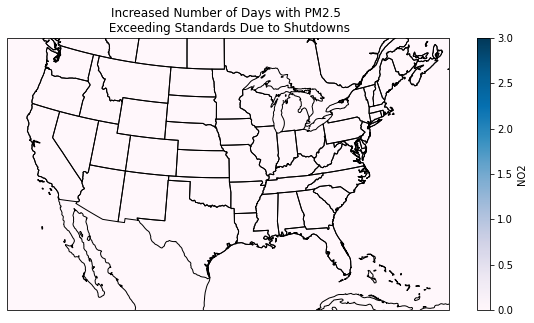

In [45]:
fig, ax = plt.subplots(figsize = (10,5), subplot_kw={'projection':ccrs.LambertConformal()})
(ds['NO2'].where(ds['NO2'] >53).count(dim = 'time').sel(model_name = 'nonuc_model') - 
    ds['NO2'].where(ds['NO2'] >53).count(dim = 'time').sel(model_name = 'normal_model')).plot(ax = ax, cmap = 'PuBu', vmin = 0, vmax = 3, transform = ccrs.PlateCarree())
ax.add_feature(cfeat.STATES)
ax.coastlines() #add coastlines
ax.set_extent([-120,-70,20,50]) #set a limit on the plot lat and lon
plt.title('Increased Number of Days with PM2.5 \n Exceeding Standards Due to Shutdowns');



## US, CH2O/NO2 Ratio and Ozone

Using the FNR ratio from Jin et al. 2017 (Evaluating a Space-Based Indicator of Surface Ozone-NOx-
VOC Sensitivity Over Midlatitude Source Regions
and Application to Decadal Trends)

<0.5 = VOC limited

0.5-0.8 = transitional

0.8> = NOx limited

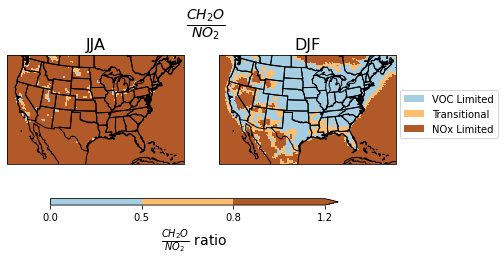

In [35]:
plotting.ratio_plot(ds = ds, species = 'CH2O_NO2',  seasons = ['JJA','DJF'], model = 'normal_model', cmap = cmap_discrete,
                       rows = 1, columns = 2, levels = [0,.5,.8,1.2], lat_lon = [-120,-70,20,50], shrink_cbar = .7,
                       figsize = [8,3])
VOC_lim = mpatches.Patch(facecolor = cmap_discrete.colors[0], label = 'VOC Limited')
trans = mpatches.Patch(facecolor = cmap_discrete.colors[1], label = 'Transitional')
NOX_lim = mpatches.Patch(facecolor = cmap_discrete.colors[2], label = 'NOx Limited')
plt.legend(handles = [VOC_lim,trans,NOX_lim], loc='upper right', bbox_to_anchor=(1.57, 18.52));
plt.title('')
plt.suptitle(r'$\frac{CH_2O}{NO_2}$', fontsize = 20, y = .98, x = .47);

plt.savefig('./Figures/regime_national_ratio.png', bbox_inches = 'tight', dpi = 150)
